# OSM tools testing

* https://download.geofabrik.de/europe/ireland-and-northern-ireland.html
* https://geoffboeing.com/2016/11/osmnx-python-street-networks/

In [2]:
import sys,os
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import seaborn as sns
import geopandas as gpd
import json

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx

import geoplot as gplt
import geoplot.crs as gcrs

from pyrosm import OSM
from pyrosm import get_data

<Axes: >

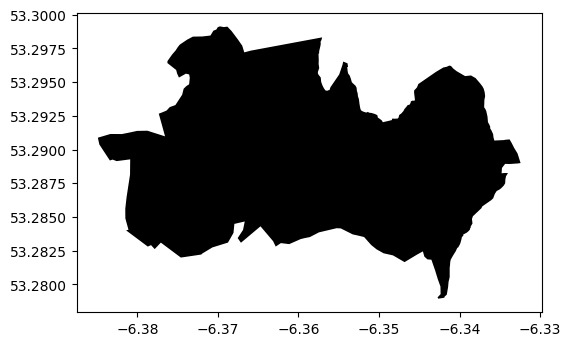

In [3]:
import osmnx as ox
place_name = "Tallaght, Ireland"
area = ox.geocode_to_gdf(place_name)
fig,ax=plt.subplots(figsize=(6,6))
area.plot(color='black',ax=ax)

## get roads etc

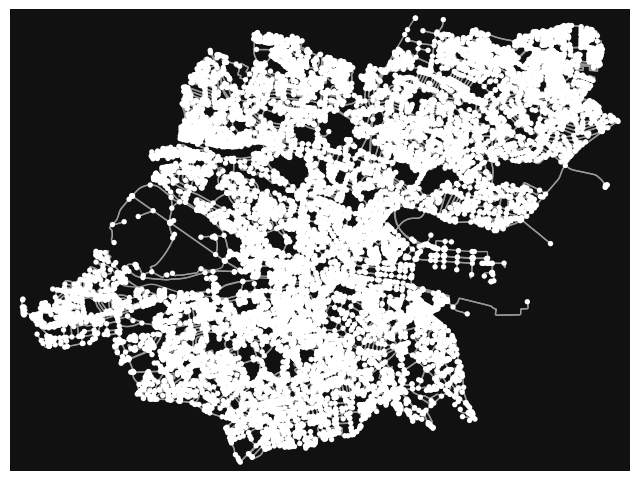

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
place='Dublin, Ireland'
G = ox.graph_from_place(place, network_type='drive')
ox.plot_graph(G)

In [7]:
basic_stats = ox.basic_stats(G)

In [ ]:
basic_stats

In [ ]:
plawater_features = ox.geometries_from_place(place, tags={'natural': 'water'})
print(water_features)

In [31]:
tiles = "cartodbpositron"
mk = {"radius": 6}
place='Ireland'
feat = ox.features_from_place(place, tags={"natural": "water"})
#feat = ox.features_from_place(place, tags={"highway": True})
#m = feat.explore(tiles=tiles, color="blue", tooltip="name", marker_kwds=mk)
#m

/home/farrell/.local/lib/python3.10/site-packages/osmnx/features.py:292: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/home/farrell/.local/lib/python3.10/site-packages/osmnx/_overpass.py:211: UserWarning: This area is 52 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  msg = (


In [40]:
cols = ['geometry']
#list(feat.columns)
x=feat.loc['way'][cols].reset_index()
x=x[x.geom_type.isin(['Polygon', 'MultiPolygon'])]
x.to_file('water.shp')

## land parcels - centre of farm building(s) vs. centroid of polygons

In [2]:
lpis = gpd.read_file('/storage/btbgenie/monaghan/LPIS/comb_2022_sum_no_com.shp').set_crs('EPSG:29902')
lpis_cent = gpd.read_file('/storage/btbgenie/monaghan/LPIS/lpis_cent.shp').set_crs('EPSG:29902')

In [3]:
parcels = lpis.cx[244000:246000,295000:296000]
bbox = list(parcels.to_crs('WGS84').total_bounds)
#print (parcels)

In [4]:
list(bbox)

[-8.615076812034173, 53.27311777071139, -6.918227851798934, 53.991464243707405]

In [12]:
#bbox = [-7.33, 53.90, -7.29, 53.91]
osm = OSM("/other/osm/ireland-and-northern-ireland-latest.osm.pbf", bbox)

In [ ]:
custom_filter = {'amenity': True, "shop": True}
pois = osm.get_pois(custom_filter=custom_filter)

In [ ]:
#get buildings
bld = osm.get_buildings()
bld = bld.to_crs('EPSG:29902')

In [ ]:
fig,ax=plt.subplots(figsize=(20,10))
parcels.plot(column='SPH_HERD_N',alpha=0.5,ax=ax)
#bld.plot(color='red',ax=ax)
ax.set_xlim(244000,246000)
ax.set_ylim(295000,296000)

In [ ]:
fig,axs=plt.subplots(4,5,figsize=(20,10))
axs=axs.flat
i=0
for n,df in parcels.sample(20).groupby('SPH_HERD_N'):
    ax=axs[i]    
    x = bld.sjoin(df, how="inner", predicate='intersects')
    if len(x)==0:
        continue
    c = x.centroid
    #print (type(c))
    #largest poly centroid
    lpc = lpis_cent[lpis_cent.SPH_HERD_N==n]
    df.plot(alpha=0.4,ax=ax)
    #x.plot(color='green',ax=ax)  
    c.plot(color='red',alpha=0.6,marker='s',ax=ax)
    lpc.plot(color='blue',ax=ax)
    i+=1
    ax.set_title(n)
    ax.axis('off')

In [ ]:
def get_farm_buildings(parcels, bld):
    x = bld.sjoin(parcels, how="inner", predicate='intersects')
    c = x.centroid
    return x,c

In [ ]:
def view_farm(df,bcent):
    """view farm parcels"""
    
    import folium
    cent = df.centroid.to_crs('WGS84')
    point = cent.iloc[0]    
    lat,lon = point.x,point.y
    print (lat,lon)
    m=folium.Map(location=[cent.geometry.y,cent.geometry.x], 
                  width=600, height=600,zoom_start=15)   
    geoj = folium.GeoJson(data=df)
    geoj.add_to(m)
    bcent = bcent.to_crs('WGS84')
    for i,r in bcent.items():       
        folium.Marker(location=[r.y,r.x], color='r').add_to(m) 
    folium.TileLayer(
            tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
            attr = 'Google',
            name = 'Google Satellite',
            overlay = True,
            control = True
    ).add_to(m)
    folium.LayerControl().add_to(m)
    return m

df=parcels[parcels.SPH_HERD_N=='B1311269']
#df=parcels.s